In [199]:
library(ggplot2)
library(dplyr)
library(gplots)
library(reshape2)
library(ggpmisc)
library(ggpubr)
library(umap)
library(ggExtra) 
library(pals)
library(RColorBrewer)
library(ComplexHeatmap)
library(circlize)

library(heatmap.plus)

In [200]:
raw<-read.table(file="./Bioskryb_DNA_final_summary.txt",header=T)
variant_anno<-read.csv(file="../../variant_annotation/780_variant_annotation_by_all_samples.csv",header=T)

In [201]:
unique(raw$Mosaic_shared_btw_WGS_Amp)

[1] 1 0

In [202]:
raw$BINARY[raw$NORMAL_UPPER_CI>raw$LOWER_CI]<-0
raw$BINARY[raw$NORMAL_UPPER_CI<raw$LOWER_CI]<-1

In [203]:
length(((raw[raw$BINARY==1,]$CHROM.POS.REF.ALT)))

[1] 53919

In [296]:
blacklist<-read.table(file="../blacklist_variants.csv",header=F)
filtered2 <- subset(raw, BINARY %in% c(1) &
                   Mosaic_shared_btw_WGS_Amp==1 &
                   !(CHROM.POS.REF.ALT %in% blacklist$V1) & 
                   CHROM.POS.REF.ALT %in% variant_anno[variant_anno$R==1 
                                                       # (variant_anno$R==1 & variant_anno$IN_only==1) | (variant_anno$R==1 & variant_anno$CTX_BG_shared==1)
                                                       # (variant_anno$Right_only==1 & variant_anno$T==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$F==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$HIP==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$CTX_BG_shared==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$CTX_HIP_shared==1) | 
                                                       # (variant_anno$Right_only==1 & variant_anno$HIP_BG_shard==1) 
                                                       ,]$variant_list &
                   Cell_Type %in% c("ExN","InN") & PLATE %in% c("PL01","PL02"))

# MV recurrency calculation
recurrency<-data.frame(t(matrix(ncol=length(unique(filtered2$CHROM.POS.REF.ALT)))))
colnames(recurrency)<-"Recurrency"
recurrency$variant<-unique(filtered2$CHROM.POS.REF.ALT)
rownames(recurrency)<-unique(filtered2$CHROM.POS.REF.ALT)
for (i in unique(filtered2$CHROM.POS.REF.ALT)){
    recurrency[i,1]<-nrow(subset(filtered2, CHROM.POS.REF.ALT==i))
}

# filter out high AF MVs
filtered2<-subset(filtered2, CHROM.POS.REF.ALT %in% recurrency[recurrency$Recurrency<15 & recurrency$Recurrency>1,]$variant)

In [297]:
blacklist<-read.table(file="../blacklist_variants.csv",header=F)
filtered <- subset(raw, SAMPLE %in% filtered2$SAMPLE &
                   CHROM.POS.REF.ALT %in% filtered2$CHROM.POS.REF.ALT &
                   Mosaic_shared_btw_WGS_Amp==1 &
                   !(CHROM.POS.REF.ALT %in% blacklist$V1) & 
                   #CHROM.POS.REF.ALT %in% variant_anno[variant_anno$R==1,]$variant_list &
                   Cell_Type %in% c("ExN","InN") & PLATE %in% c("PL01","PL02"))

In [298]:
# MV recurrency calculation
recurrency<-data.frame(t(matrix(ncol=length(unique(filtered$CHROM.POS.REF.ALT)))))
colnames(recurrency)<-"Recurrency"
recurrency$variant<-unique(filtered$CHROM.POS.REF.ALT)
rownames(recurrency)<-unique(filtered$CHROM.POS.REF.ALT)
for (i in unique(filtered$CHROM.POS.REF.ALT)){
    recurrency[i,1]<-nrow(subset(filtered, CHROM.POS.REF.ALT==i &  BINARY==1))
}

In [299]:
# filter out high AF MVs
filtered<-subset(filtered, CHROM.POS.REF.ALT %in% recurrency[recurrency$Recurrency<15 & recurrency$Recurrency>1,]$variant)

In [300]:
length(unique((filtered[filtered$BINARY==1,]$CHROM.POS.REF.ALT)))
length(((filtered[filtered$BINARY==1,]$CHROM.POS.REF.ALT)))

[1] 68

[1] 310

In [301]:
nrow(filtered)
colnames(filtered)

[1] 8024

[1] "ID"                        "PLATE"                    
 [3] "SAMPLE"                    "CHROM"                    
 [5] "POS"                       "REF"                      
 [7] "ALT"                       "INDIVIDUAL"               
 [9] "CHROM.POS.REF.ALT"         "Mosaic"                   
[11] "ANNO"                      "GENE"                     
[13] "GNOMAD_FREQ"               "REPEAT_MASKER"            
[15] "SEGDUP"                    "HOMOPOLYMER"              
[17] "REF_SEQ"                   "DINUCLEOTIDE"             
[19] "NEAR_INDEL"                "UCSC_RPMSK"               
[21] "DEPTH"                     "REF_COUNT"                
[23] "ALT_COUNT"                 "MAF"                      
[25] "LOWER_CI"                  "UPPER_CI"                 
[27] "CI_IS_GREATER"             "NORMAL_REF_COUNT"         
[29] "NORMAL_ALT_COUNT"          "NORMAL_MAF"               
[31] "NORMAL_LOWER_CI"           "NORMAL_UPPER_CI"          
[33] "NORMAL_CI_IS_GREATER"      "Mosaic_shared_btw_WGS_Amp"
[35] "BINARY"                    "Cell_Type"

In [302]:
#description of filtered data frame 
print(paste("number of variants:", length(unique(filtered$CHROM.POS.REF.ALT))))
print(paste("number of cells:", length(unique(filtered$SAMPLE))))
print(paste("number of Excitatory neurons:", length(unique(filtered[filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of Inhibitory neurons:", length(unique(filtered[filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of cells in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01",]$SAMPLE))))
print(paste("number of cells in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02",]$SAMPLE))))
print(paste("number of cells in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03",]$SAMPLE))))
print(paste("number of ExN in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of ExN in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of ExN in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03" & filtered$Cell_Type=="ExN",]$SAMPLE))))
print(paste("number of InN in Frontal lobe:", length(unique(filtered[filtered$PLATE=="PL01" & filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of InN in Temporal lobe:", length(unique(filtered[filtered$PLATE=="PL02" & filtered$Cell_Type=="InN",]$SAMPLE))))
print(paste("number of InN in Hippocampus:", length(unique(filtered[filtered$PLATE=="PL03" & filtered$Cell_Type=="InN",]$SAMPLE))))

[1] "number of variants: 68"
[1] "number of cells: 118"
[1] "number of Excitatory neurons: 85"
[1] "number of Inhibitory neurons: 33"
[1] "number of cells in Frontal lobe: 56"
[1] "number of cells in Temporal lobe: 62"
[1] "number of cells in Hippocampus: 0"
[1] "number of ExN in Frontal lobe: 40"
[1] "number of ExN in Temporal lobe: 45"
[1] "number of ExN in Hippocampus: 0"
[1] "number of InN in Frontal lobe: 16"
[1] "number of InN in Temporal lobe: 17"
[1] "number of InN in Hippocampus: 0"


In [303]:
df<-data.frame(matrix(NA, nrow=4*length(unique(filtered$CHROM.POS.REF.ALT)), ncol=6))
colnames(df)<-c("CHROM.POS.REF.ALT","Region","Cell_Type","MAF","UPPER_CI","LOWER_CI")

In [304]:
totalcellinfo<-data.frame(t(matrix(ncol=2,nrow=2)))
colnames(totalcellinfo)<-c("ExN","InN")
rownames(totalcellinfo)<-c("PL01","PL02")
totalcellinfo["PL01",]<-c(45,16)
totalcellinfo["PL02",]<-c(63,25)

In [305]:
totalcellinfo

,ExN,InN
,<dbl>,<dbl>
PL01,45,16
PL02,63,25


In [306]:
temp<-1
for (i in unique(filtered$CHROM.POS.REF.ALT)){
    for (j in c("ExN","InN")){
        for (k in c("PL01","PL02")){
        df$CHROM.POS.REF.ALT[temp]<-i
        df$Cell_Type[temp]<-j
        df$Region[temp]<-k
        pos_cells<-length(unique(filtered[filtered$PLATE %in% k & filtered$Cell_Type %in% j & filtered$CHROM.POS.REF.ALT %in% i & filtered$BINARY == 1,]$SAMPLE))
        total_cells<-totalcellinfo[k,j]
        df$MAF[temp]<-pos_cells/total_cells
        temp<-temp+1
        }}}

In [307]:
melt_mtcars<-df#rbind(selected_sorted[,c("CHROM.POS.REF.ALT","Region","Cell_Type","MAF")],df[,c("CHROM.POS.REF.ALT","Region","Cell_Type","MAF")])
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF/2)

In [308]:
casted_MAF_VarBySample2 <- dcast(melt_mtcars, Region+Cell_Type~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample2) <- paste0(casted_MAF_VarBySample2$Region,casted_MAF_VarBySample2$Cell_Type)
nrow(casted_MAF_VarBySample2)

unique(casted_MAF_VarBySample2$Region)
unique(casted_MAF_VarBySample2$Cell_Type)

[1] 4

[1] "PL01" "PL02"

[1] "ExN" "InN"

In [309]:
Normalized_casted_MAF_VarBySample2<-t((t(casted_MAF_VarBySample2[,-1:-2]))) # remove annotation columns
label<-t(t(casted_MAF_VarBySample2[,1:2]))
label<-as.data.frame(label)

In [310]:
left_right_cell_col_ann <- HeatmapAnnotation(simple_anno_size = unit(0.5, "cm"), 
                                             which = "row",
                                             #Hemisphere = label$Hemisphere,
                                             Region = label$Region,
                                             Cell_Type = label$Cell_Type,
                                             col = list(Region = c("PL01"="#CBDF00","PL02"="#00DF3D","PL03"="#9200DF"),
                                                        Cell_Type = c("InN" = "#EF6666", "ExN" = "#7CBD42"))
                                             )

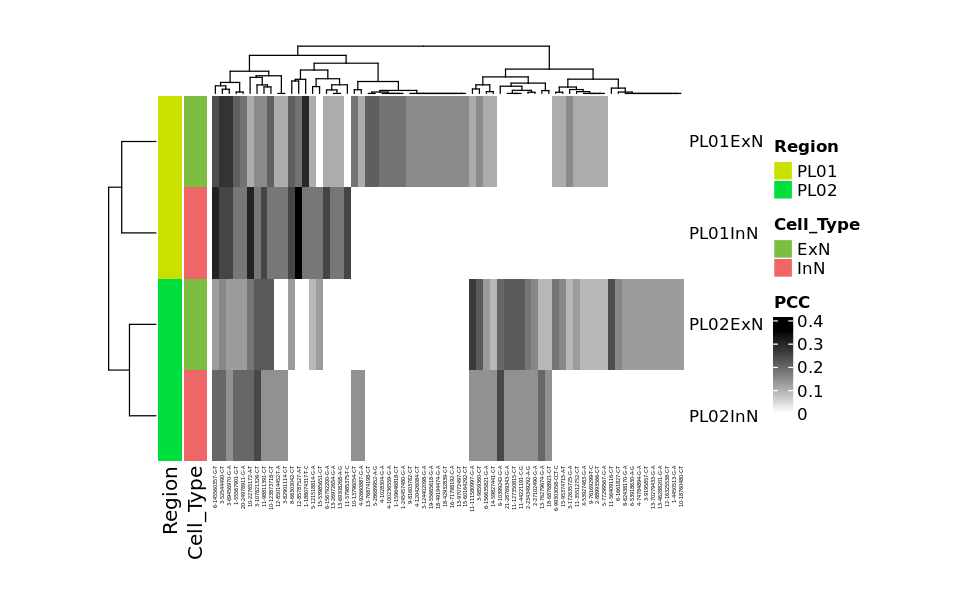

In [311]:
options(repr.plot.width = 8, repr.plot.height = 5)
p<-Heatmap(Normalized_casted_MAF_VarBySample2,
        col = c("white", "black"),
        row_names_gp = gpar(fontsize = "10"), column_names_gp = gpar(fontsize = "3"),
        name = "PCC",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(10, "cm"),
        heatmap_height = unit(10, "cm")) 
p

In [312]:
pdf(file="ResolveOME_DNA2_4_pseudobulk_heatmap.pdf",height=24,width=40)
p
dev.off()   

png 
  2

In [313]:
sort <- read.table("../../20230101_QC/final_summary_anno3.txt",header=T,sep="\t")
sort<-subset(sort, CHROM.POS.REF.ALT %in% filtered$CHROM.POS.REF.ALT &
            Cell_Type %in% c("TBR1","DLX1","COUPTF2") & 
            Hemisphere %in% c("R") &
            Region %in% c("F","T"))

In [314]:
melt_mtcars2<-sort[,c("ID", "MAF", "CHROM.POS.REF.ALT","Cell_Type","Organ",'Region','Punch','Sort_main','Hemisphere')]
melt_mtcars2$MAF <- sqrt(melt_mtcars2$MAF)

In [315]:
melt_mtcars2<-na.omit(melt_mtcars2)

In [316]:
max(melt_mtcars$MAF)

[1] 0.3535534

In [317]:
melt_mtcars3<-rbind((melt_mtcars[,c("CHROM.POS.REF.ALT","Region","Cell_Type","MAF")]),
(melt_mtcars2[,c("CHROM.POS.REF.ALT","Region","Cell_Type","MAF")]))

In [318]:
casted_MAF_VarBySample <- dcast(melt_mtcars3, Region+Cell_Type~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)

In [319]:
rownames(casted_MAF_VarBySample)<-paste0(casted_MAF_VarBySample$Region,"-",casted_MAF_VarBySample$Cell_Type)

In [320]:
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,]
nrow(casted_MAF_VarBySample2)
unique(casted_MAF_VarBySample2$Region)
unique(casted_MAF_VarBySample2$Cell_Type)

[1] 10

[1] "F"    "PL01" "PL02" "T"

[1] "COUPTF2" "DLX1"    "TBR1"    "ExN"     "InN"

In [321]:
Normalized_casted_MAF_VarBySample2<-t(na.omit(t(casted_MAF_VarBySample2[,-1:-2])))

In [322]:
casted_MAF_VarBySample2$Region
casted_MAF_VarBySample2$Cell_Type

[1] "F"    "F"    "F"    "PL01" "PL01" "PL02" "PL02" "T"    "T"    "T"

[1] "COUPTF2" "DLX1"    "TBR1"    "ExN"     "InN"     "ExN"     "InN"    
 [8] "COUPTF2" "DLX1"    "TBR1"

In [323]:
label<-t(na.omit(t(casted_MAF_VarBySample2[,1:2])))
label<-as.data.frame(label)

In [324]:
left_right_cell_col_ann <- HeatmapAnnotation(simple_anno_size = unit(0.5, "cm"), 
                                             which = "row",
                                             Region = label$Region,
                                             Cell_Type = label$Cell_Type,
                                             col = list(Region = c("F"="red",
                                                                  "T"="blue",
                                                                   "PL01"="#C663A5",
                                                                   "PL02"="#FFC022"
                                                                 ),
                                                       Cell_Type = c("DLX1" = "#EF6666", "TBR1" = "#7CBD42","COUPTF2"="#5FBEEB","ExN"="#7CBD42","InN"="#EF6666"))
                                             )

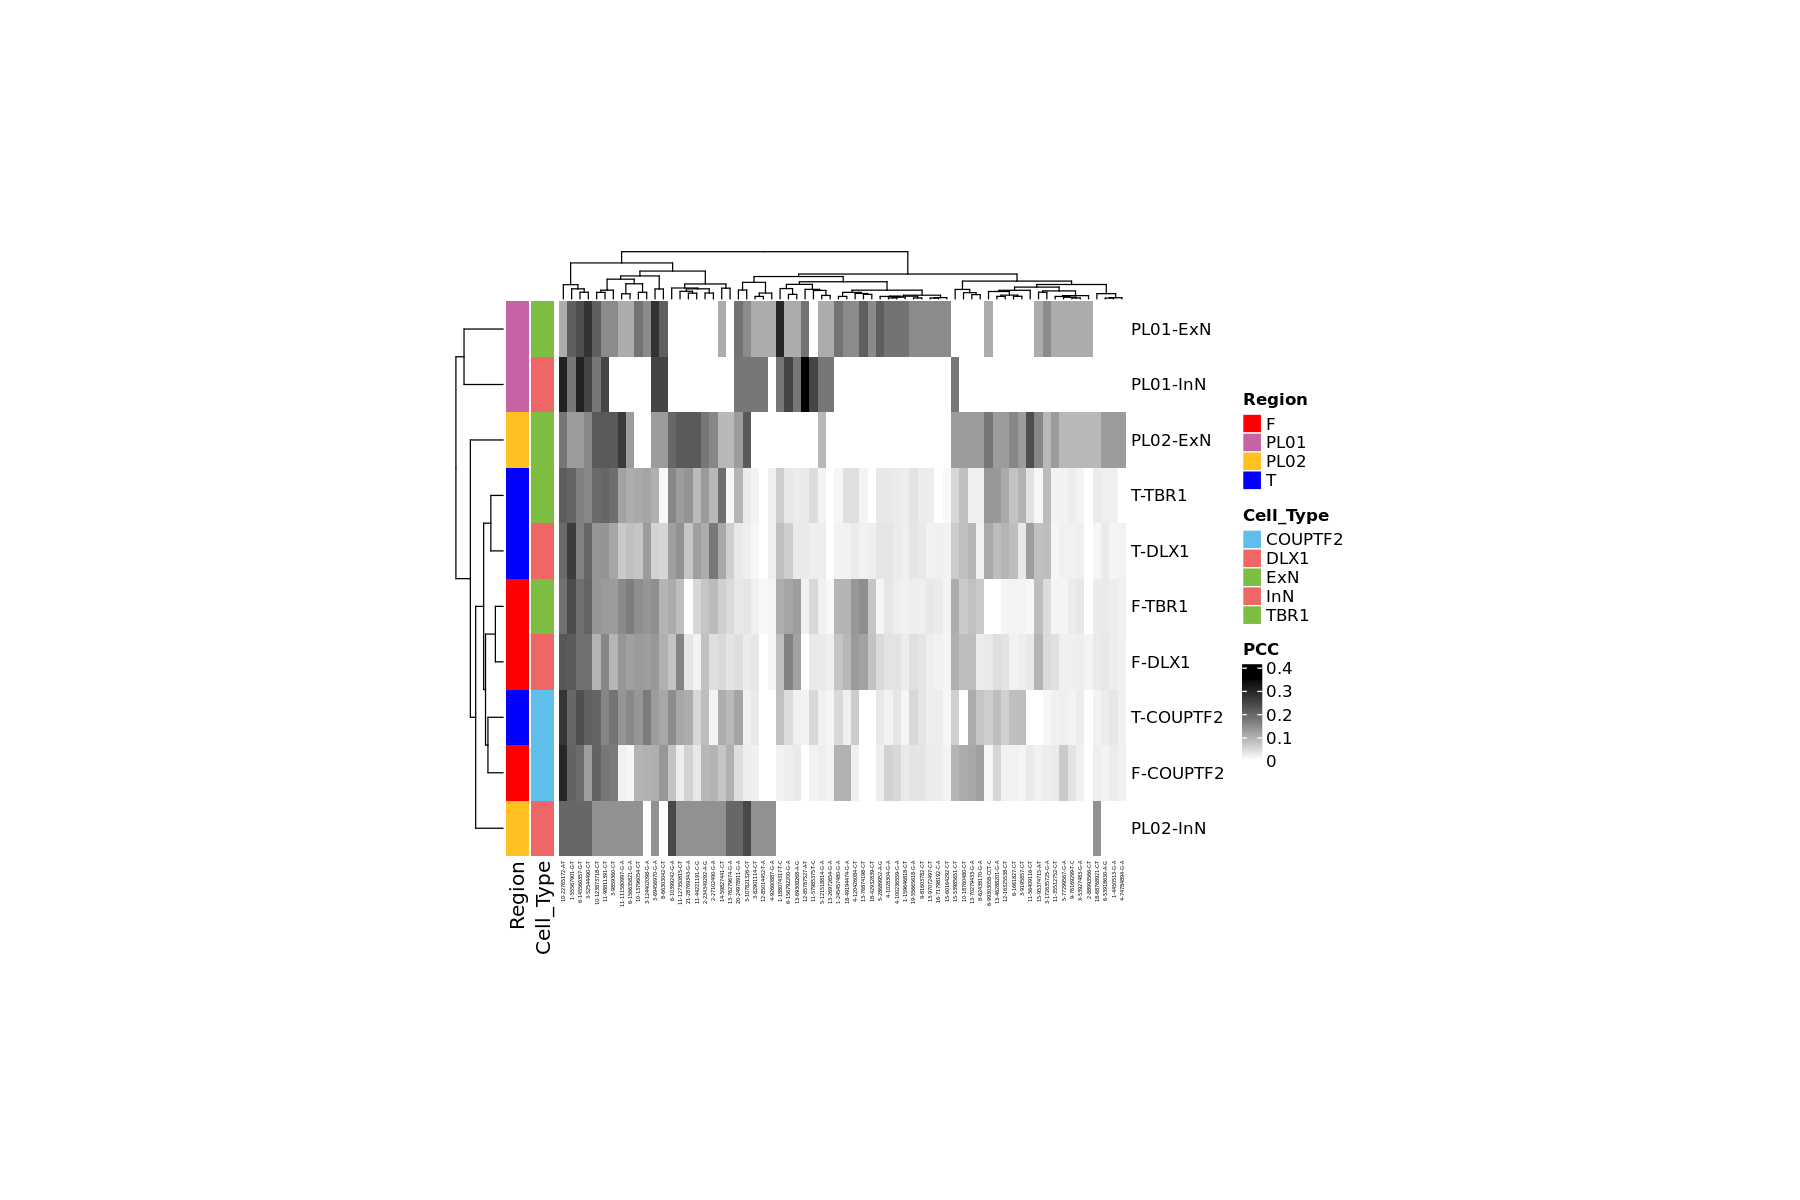

In [326]:
options(repr.plot.width = 15, repr.plot.height = 10)
p<-Heatmap(Normalized_casted_MAF_VarBySample2,
        col = c("white", "black"),
        row_names_gp = gpar(fontsize = "10"), column_names_gp = gpar(fontsize = "3"),
        name = "PCC",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "euclidean", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(12, "cm"),
        heatmap_height = unit(14, "cm")) 
p

In [327]:
pdf(file="ResolveOME_DNA2_4_pseudobulk_sort_comparison_heatmap.pdf",height=24,width=40)
p
dev.off()   

png 
  2

In [328]:
cor<-t(casted_MAF_VarBySample[,-1:-2])
colnames(cor)<-c('F_COUPTF2','F_DLX1','F_TBR1','PL01_ExN','PL01_InN','PL02_ExN','PL02_InN','T_COUPTF2','T_DLX1','T_TBR1')
cor<-(data.frame(cor))
cor

,F_COUPTF2,F_DLX1,F_TBR1,PL01_ExN,PL01_InN,PL02_ExN,PL02_InN,T_COUPTF2,T_DLX1,T_TBR1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1-159646818-C-T,0.02703526,0.02322354,0.017512893,0.1825742,0.0000000,0.00000000,0.0000000,0.01206923,0.01927537,0.020589910
1-188074317-T-C,0.01694064,0.08000409,0.103425263,0.2981424,0.1767767,0.00000000,0.0000000,0.07763510,0.08009617,0.061886592
1-245457480-G-A,0.09841984,0.07236666,0.093487644,0.1825742,0.0000000,0.00000000,0.0000000,0.04702248,0.01513127,0.011505659
1-4450513-G-A,0.02376830,0.02186138,0.021851539,0.0000000,0.0000000,0.12598816,0.0000000,0.02955916,0.01397542,0.019096353
1-55567901-G-T,0.20582857,0.21678622,0.237700543,0.2108185,0.1767767,0.12598816,0.2000000,0.19880055,0.26311375,0.202085949
10-123873718-C-T,0.20474617,0.09501707,0.135638918,0.2108185,0.1767767,0.21821789,0.1414214,0.20201269,0.13408301,0.194906443
10-13796054-C-T,0.09512078,0.12677941,0.144972843,0.1825742,0.0000000,0.00000000,0.1414214,0.13355658,0.07077349,0.108262787
10-18760480-C-T,0.10458370,0.08186457,0.066413167,0.0000000,0.0000000,0.12598816,0.0000000,0.00000000,0.07981928,0.078554197
10-22765172-A-T,0.29981268,0.22247460,0.185543066,0.1054093,0.3061862,0.17817416,0.2000000,0.27528184,0.19576624,0.214012913


In [329]:
p1<-ggplot(cor, aes(x=F_COUPTF2, y=PL01_InN)) + geom_point() + xlim(0,0.5) + ylim(0,0.5)
p2<-ggplot(cor, aes(x=F_DLX1, y=PL01_InN)) + geom_point() + xlim(0,0.5) + ylim(0,0.5)
p3<-ggplot(cor, aes(x=F_TBR1, y=PL01_InN)) + geom_point() + xlim(0,0.5) + ylim(0,0.5)
p4<-ggplot(cor, aes(x=T_COUPTF2, y=PL02_InN)) + geom_point() + xlim(0,0.5) + ylim(0,0.5)
p5<-ggplot(cor, aes(x=T_DLX1, y=PL02_InN)) + geom_point() + xlim(0,0.5) + ylim(0,0.5)
p6<-ggplot(cor, aes(x=T_TBR1, y=PL02_InN)) + geom_point() + xlim(0,0.5) + ylim(0,0.5)
p7<-ggplot(cor, aes(x=F_COUPTF2, y=PL01_ExN)) + geom_point() + xlim(0,0.5) + ylim(0,0.5)
p8<-ggplot(cor, aes(x=F_DLX1, y=PL01_ExN)) + geom_point() + xlim(0,0.5) + ylim(0,0.5)
p9<-ggplot(cor, aes(x=F_TBR1, y=PL01_ExN)) + geom_point() + xlim(0,0.5) + ylim(0,0.5)
p10<-ggplot(cor, aes(x=T_COUPTF2, y=PL02_ExN)) + geom_point() + xlim(0,0.5) + ylim(0,0.5)
p11<-ggplot(cor, aes(x=T_DLX1, y=PL02_ExN)) + geom_point() + xlim(0,0.5) + ylim(0,0.5)
p12<-ggplot(cor, aes(x=T_TBR1, y=PL02_ExN)) + geom_point() + xlim(0,0.5) + ylim(0,0.5)

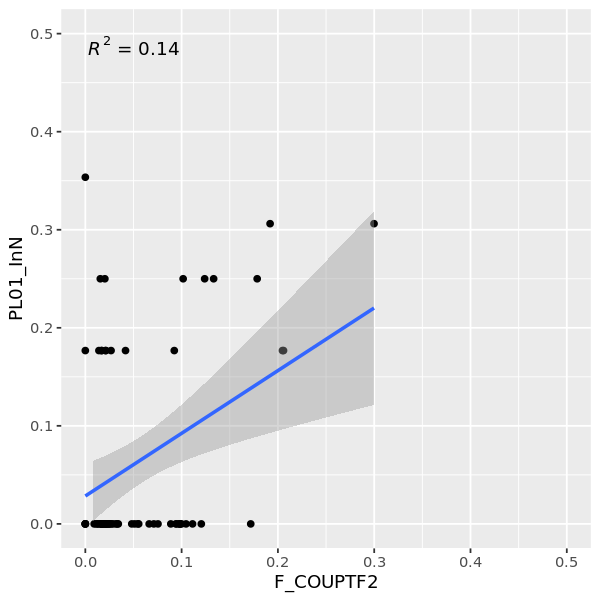

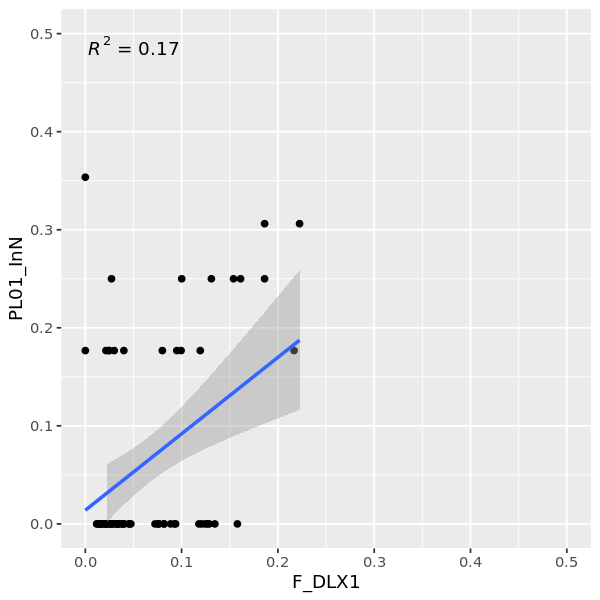

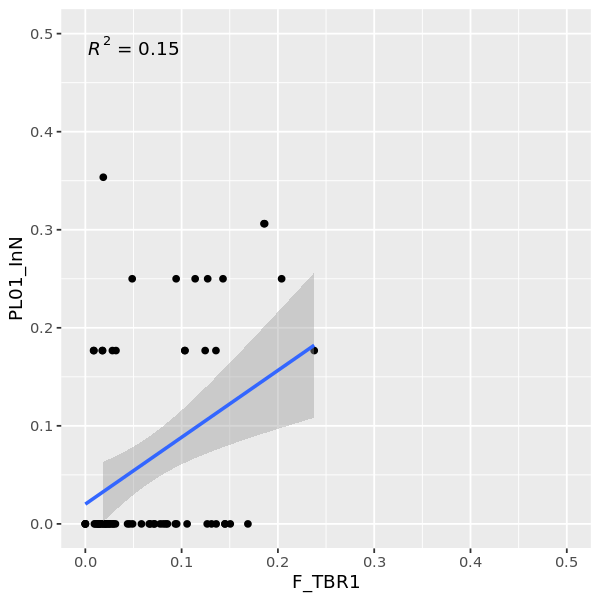

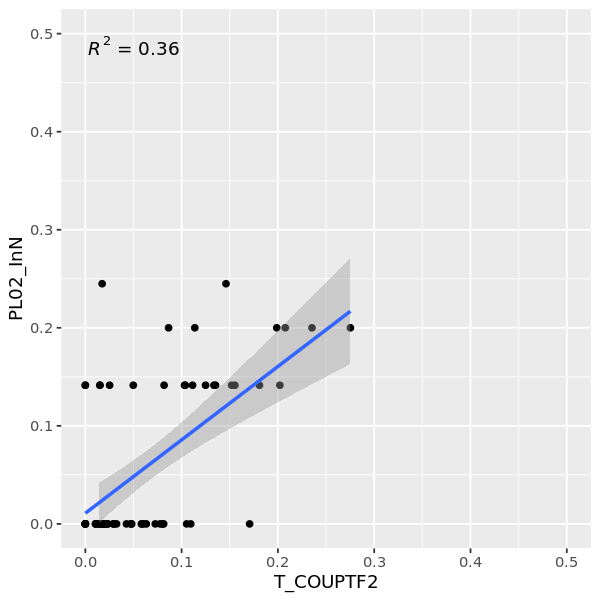

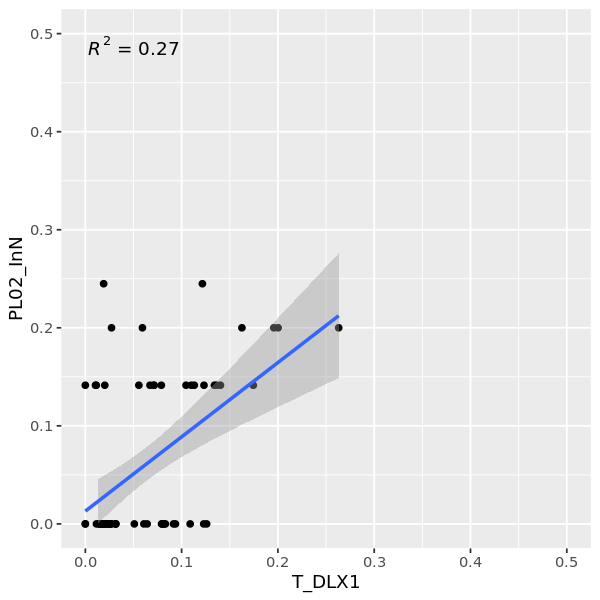

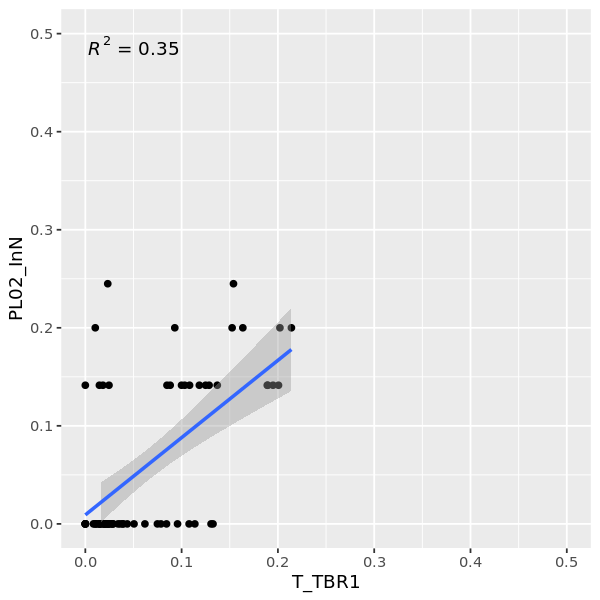

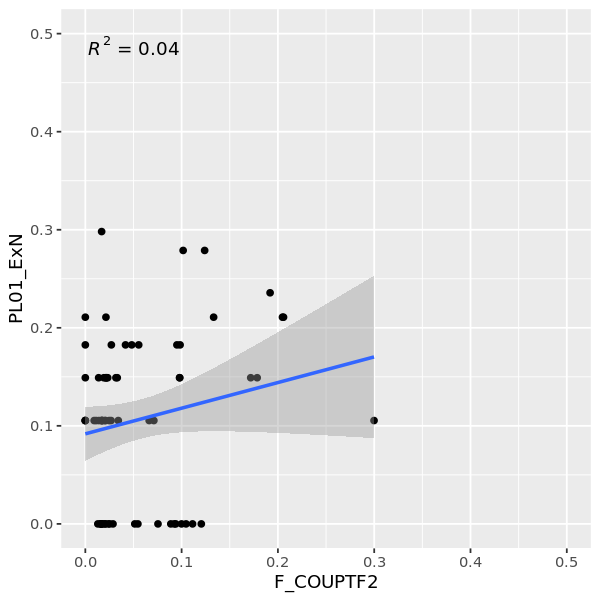

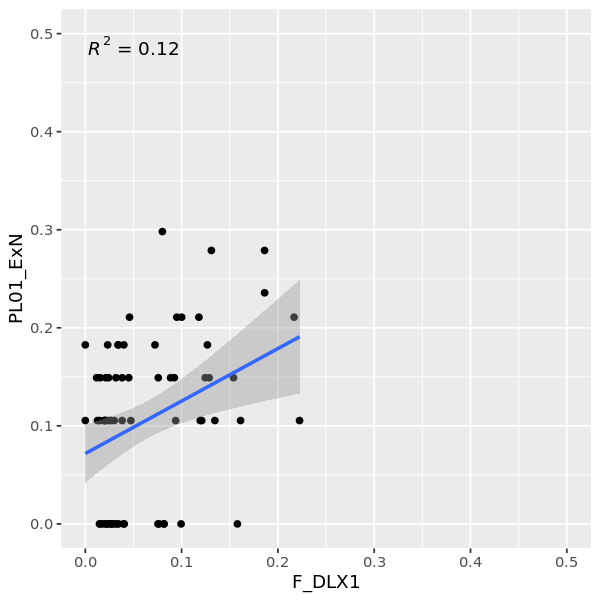

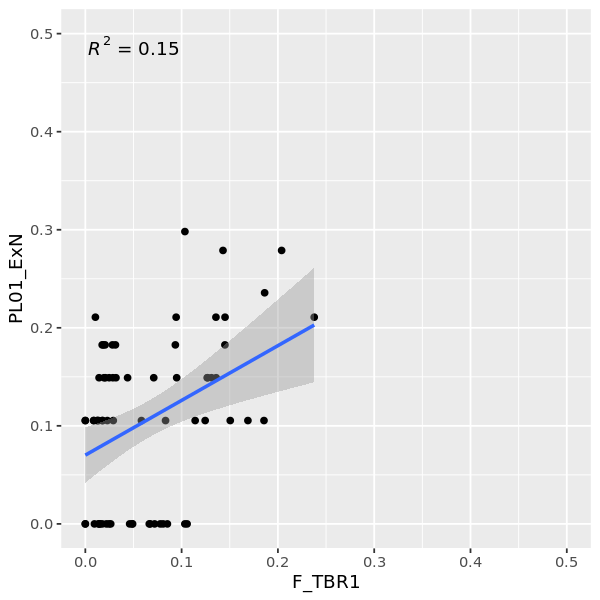

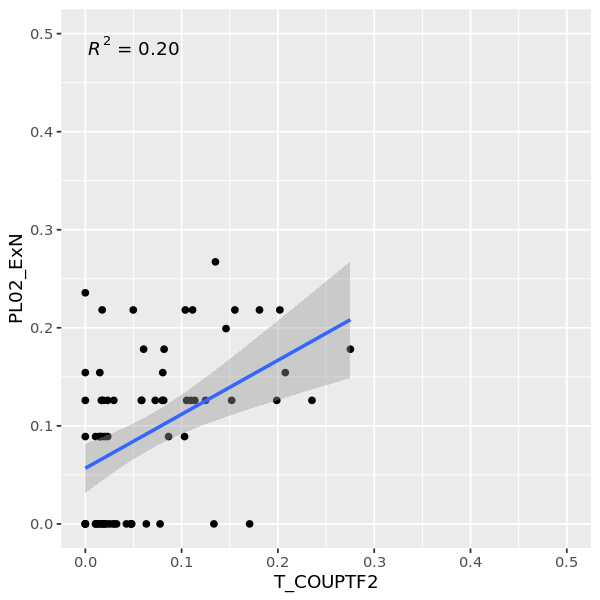

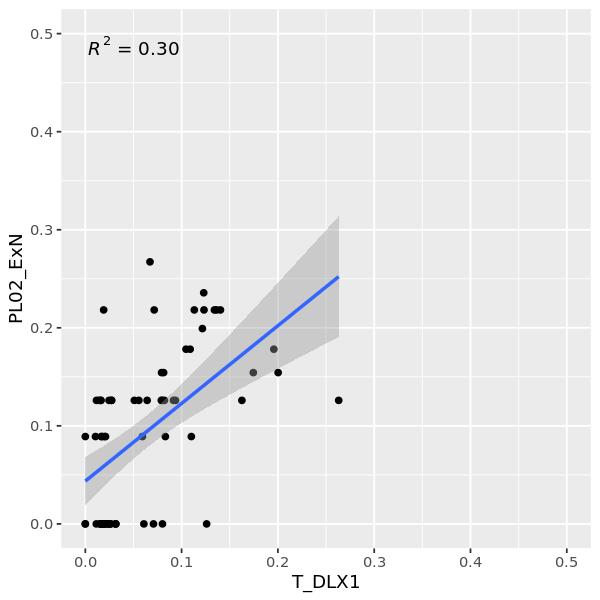

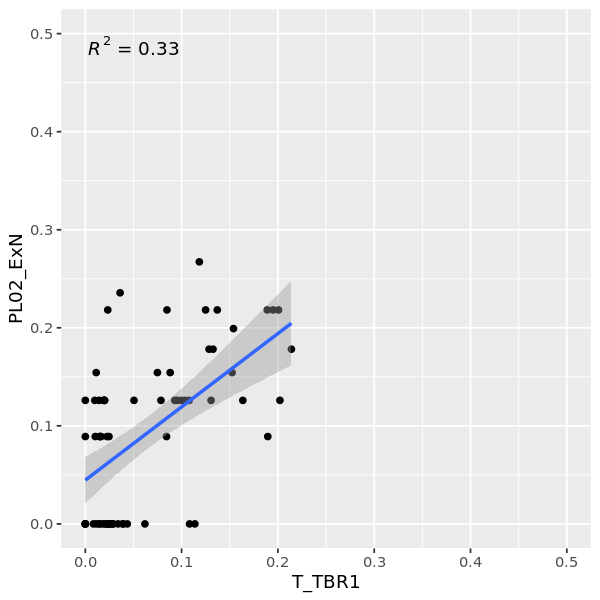

In [330]:
options(repr.plot.width = 5, repr.plot.height = 5)
p1+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm")
p2+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm")
p3+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm")
p4+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm")
p5+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm")
p6+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm")
p7+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm")
p8+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm")
p9+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm")
p10+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm")
p11+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm")
p12+stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")+stat_poly_eq(formula = y ~ x,method = "lm")
